## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density
4. Number of free ribosomes

In [2]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

In [4]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150818_1920_3599s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [5]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [6]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [7]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [8]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

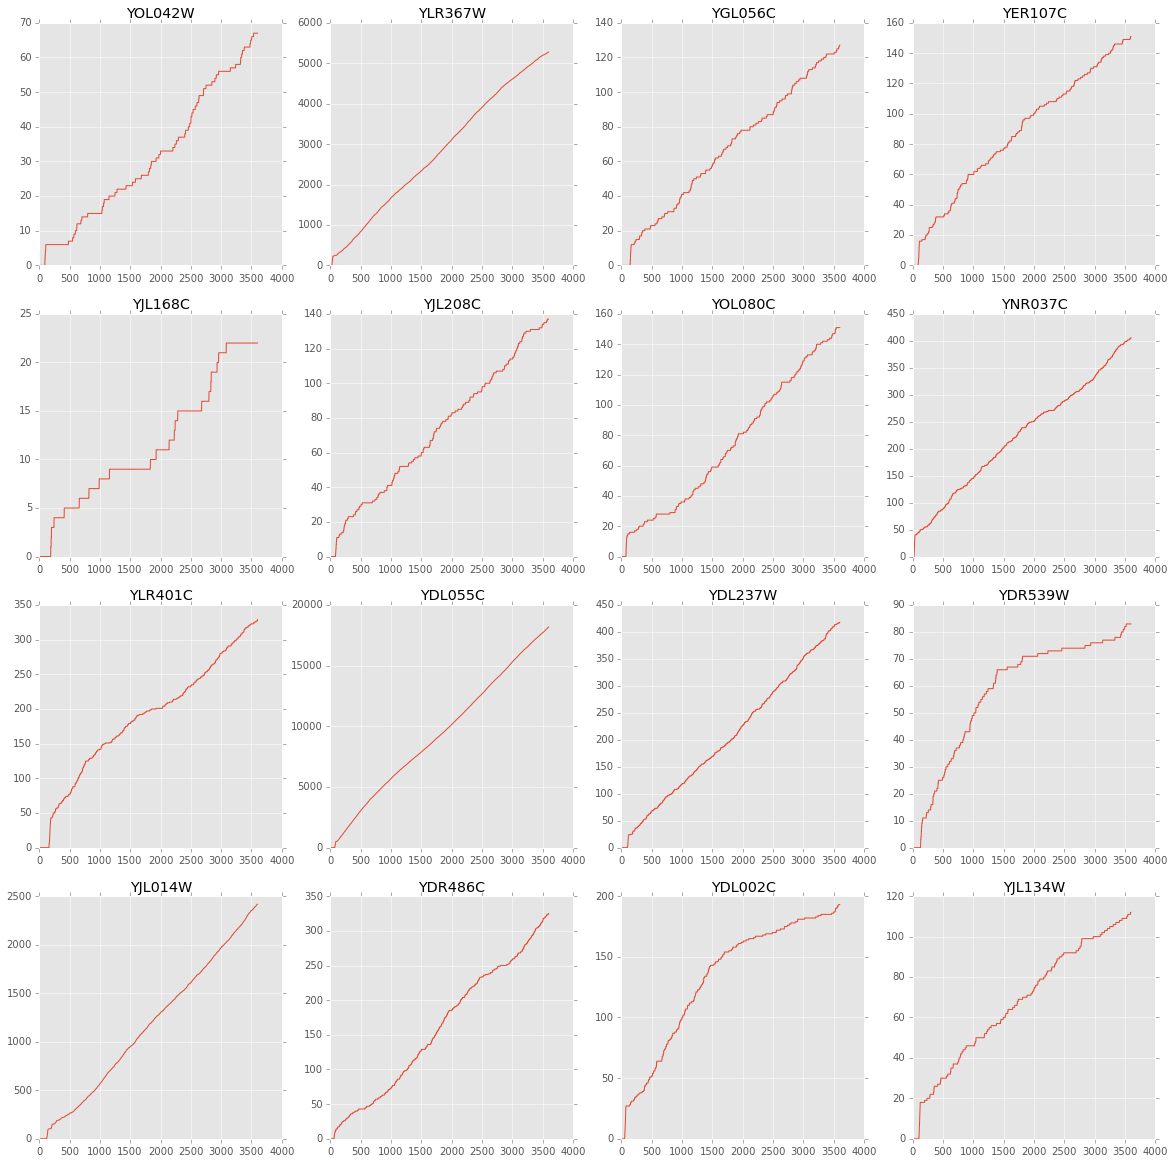

In [9]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation:

In [14]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 78.9
YAL038W 113.273333333
YCR012W 62.2076666667
YOL086C 50.837
YLR044C 255.591666667
YOL040C 52.4876666667


In [15]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        1.035836
std         6.943294
min         0.000667
25%         0.024667
50%         0.070000
75%         0.243000
max       255.591667
dtype: float64

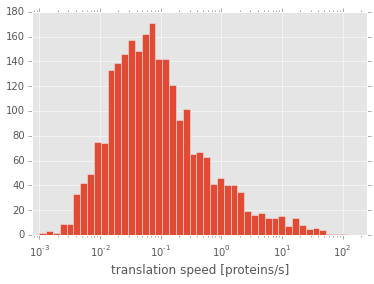

In [16]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [17]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [18]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [19]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean        377.096605
std        3414.163554
min           0.340000
25%           9.370333
50%          25.617833
75%          87.378250
max      144153.700000
dtype: float64

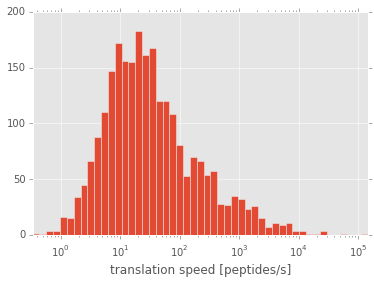

In [20]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [21]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [27]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [23]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [24]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

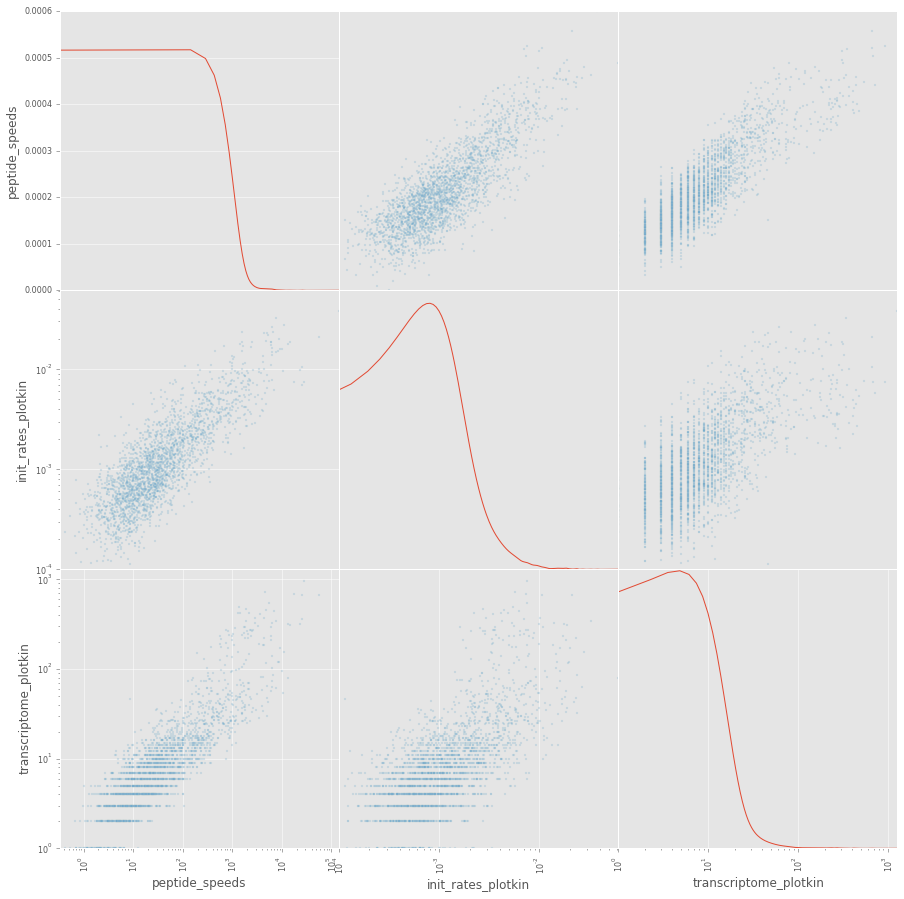

In [25]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which was created using `detail=True`, i.e. contains ribosomes at all times:

In [46]:
filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150819_1601_0019s.p"

In [47]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

In [48]:
ribosome_timecourses = {key: results['timecourses'][key] for key in results['timecourses'] if key.startswith('mRNA_')}

In [49]:
ribosome_timecourses.keys()

['mRNA_13113',
 'mRNA_13112',
 'mRNA_13111',
 'mRNA_13110',
 'mRNA_13117',
 'mRNA_13116',
 'mRNA_13115',
 'mRNA_13114',
 'mRNA_11014',
 'mRNA_13119',
 'mRNA_13118',
 'mRNA_11015',
 'mRNA_00108',
 'mRNA_00109',
 'mRNA_00458',
 'mRNA_00459',
 'mRNA_11016',
 'mRNA_00100',
 'mRNA_00101',
 'mRNA_00102',
 'mRNA_00103',
 'mRNA_00104',
 'mRNA_00105',
 'mRNA_00106',
 'mRNA_00107',
 'mRNA_16412',
 'mRNA_07001',
 'mRNA_01859',
 'mRNA_01858',
 'mRNA_01855',
 'mRNA_01854',
 'mRNA_01857',
 'mRNA_01856',
 'mRNA_01851',
 'mRNA_01850',
 'mRNA_01853',
 'mRNA_01852',
 'mRNA_06077',
 'mRNA_16099',
 'mRNA_16098',
 'mRNA_16091',
 'mRNA_16090',
 'mRNA_16093',
 'mRNA_16092',
 'mRNA_16095',
 'mRNA_16094',
 'mRNA_16097',
 'mRNA_16096',
 'mRNA_01451',
 'mRNA_01450',
 'mRNA_10213',
 'mRNA_01981',
 'mRNA_15407',
 'mRNA_15406',
 'mRNA_15405',
 'mRNA_15404',
 'mRNA_15403',
 'mRNA_15402',
 'mRNA_15401',
 'mRNA_15400',
 'mRNA_01455',
 'mRNA_15409',
 'mRNA_01454',
 'mRNA_04225',
 'mRNA_04224',
 'mRNA_04227',
 'mRNA_042

In [50]:
ribosome_timecourses['mRNA_13113']

[{12: None},
 {18: None},
 {27: None},
 {45: None},
 {12: None, 60: None},
 {27: None, 69: None},
 {39: None, 81: None},
 {12: None, 48: None, 99: None},
 {24: None, 57: None, 117: None},
 {33: 15, 63: None, 132: None},
 {9: None, 42: 8, 72: None, 147: None},
 {24: None, 54: None, 90: None, 159: None},
 {33: None, 66: None, 111: None, 168: None},
 {15: None, 45: None, 81: None, 123: None, 177: None},
 {27: None, 60: None, 96: None, 135: None, 192: None},
 {36: 7, 66: None, 111: None, 147: None, 207: None},
 {12: None, 48: None, 81: None, 123: None, 156: None, 219: None},
 {27: None, 60: None, 99: None, 138: None, 174: None, 231: None},
 {36: 7, 66: None, 114: None, 153: None, 183: None, 240: None},
 {9: None, 48: None, 81: None, 129: None, 165: None, 195: None, 255: None}]